## install and import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [22]:
!pip install geoconformal

In [5]:
!pip install geopandas
!pip install contextily
!pip install xgboost
!pip install geoplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 110.6 MB/s eta 0:00:00


In [23]:
import xgboost as xgb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.model_selection import train_test_split
import contextily as cx
from geoconformal import GeoConformalSpatialRegression

## import data

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Research/0_GeoCP_with_geosimilarity/data/seattle_sample_3k.csv')

In [8]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [9]:
data = data.to_crs(4326)

In [10]:
data['lat'] = data['geometry'].get_coordinates()['x']
data['lon'] = data['geometry'].get_coordinates()['y']

In [11]:
data['price'] = np.power(10, data['log_price']) / 10000

In [12]:
data

,Unnamed: 0,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y,log_price,geometry,lat,lon,price
0,0,3.00,2660,4600,8,3,0,0,109,552217.557035,5.274945e+06,6.091315,POINT (-122.305 47.6258),-122.305,47.6258,123.4000
1,1,2.25,2530,8736,7,4,0,0,57,565692.484331,5.272758e+06,5.790988,POINT (-122.126 47.6049),-122.126,47.6049,61.8000
2,2,2.00,1390,13464,7,4,0,0,28,562451.661509,5.245291e+06,5.315130,POINT (-122.173 47.3581),-122.173,47.3581,20.6600
3,3,1.00,940,4264,7,5,0,0,66,546816.935618,5.264407e+06,5.619093,POINT (-122.378 47.5314),-122.378,47.5314,41.6000
4,4,2.25,2070,7225,8,3,0,0,36,564343.195352,5.244978e+06,5.477121,POINT (-122.148 47.3551),-122.148,47.3551,30.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,1.50,1290,8366,7,3,0,0,58,551377.991268,5.259321e+06,5.380211,POINT (-122.318 47.4853),-122.318,47.4853,24.0000
2996,2996,1.50,1490,12186,7,4,0,0,65,550796.231636,5.291393e+06,5.566895,POINT (-122.322 47.7739),-122.322,47.7739,36.8888
2997,2997,1.50,1510,16800,8,5,0,0,59,549619.278143,5.288838e+06,5.618048,POINT (-122.338 47.751),-122.338,47.7510,41.5000
2998,2998,2.00,1640,3021,7,3,0,2,56,548198.517745,5.279378e+06,5.732394,POINT (-122.358 47.666),-122.358,47.6660,54.0000


In [13]:
y = data.price
X_aspatial = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age']]
X_spatial = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
loc = data[['lat','lon']]

## Split dataset

In [14]:
X_aspatial_train, X_apsatial_temp, X_spatial_train, X_spatial_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X_aspatial, X_spatial, y, loc, train_size=0.8, random_state=42)

In [15]:
X_aspatial_val, X_aspatial_test, X_spatial_val, X_spatial_test, y_val, y_test, loc_val, loc_test = train_test_split(X_apsatial_temp, X_spatial_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

## Prediction model training

In [16]:
model_spatial = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [17]:
model_spatial.fit(X_spatial_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Geographic uncertainty

In [24]:
geocp_spatial = GeoConformalSpatialRegression(predict_f=model_spatial.predict, nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=0.15, coord_calib=loc_val.values, coord_test=loc_test.values, X_calib=X_spatial_val, y_calib=y_val, X_test=X_spatial_test, y_test=y_test)

In [25]:
results = geocp_spatial.analyze()

In [26]:
results.uncertainty

np.float64(18.16879501342758)

In [27]:
results.coverage_probability

np.float64(0.9366666666666666)

In [28]:
results_geo = results.to_gpd()

<GeoAxes: >

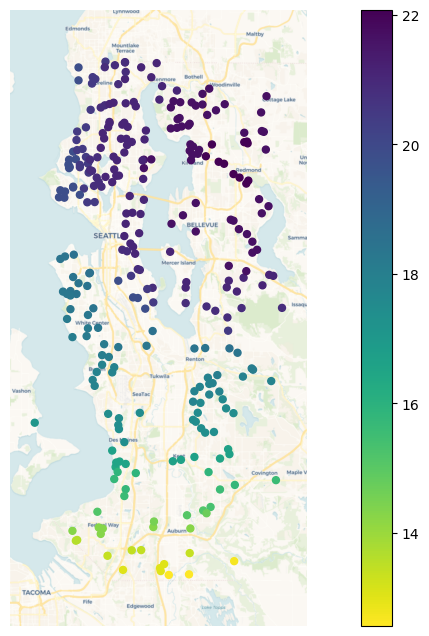

In [29]:
utm = gcrs.WebMercator()

ax = gplt.webmap(results_geo, projection=utm, figsize=(14, 8), provider=cx.providers.CartoDB.Voyager)

gplt.pointplot(results_geo, hue='geo_uncertainty', cmap='viridis_r', legend=True, ax=ax)